In [1]:
from model import load_model
from read import read_simlex, read_analogies, read_nouns
from scipy.stats import pearsonr, spearmanr
import numpy as np
import numpy as np
import marshal
import json

In [2]:
def read_men(file_name):
    def parse_line(line):
        return {
            'word1': line[0].replace('-n', ''),
            'word2': line[1].replace('-n', ''), 
            'similarity': float(line[2])
        }
    with open(file_name, 'r') as file:
        return [parse_line(line.split()) for line in file]
    

men = read_men('./MEN/MEN_dataset_lemma_form_full')

In [43]:
def norm(vector):
    return vector / np.linalg.norm(vector)

def lazy_read(file):
    get_word_and_vector = lambda line: (line[0], [float(x) for x in line[1:]])
    for line in file:
        yield get_word_and_vector(line.split())

def read_from_disk(file_name):
    with open('raw_models/{0}'.format(file_name), 'r') as file:
        words, X = zip(*lazy_read(file))
    return {word: i for i, word in enumerate(words)}, X

def load_model(file_name):
    try:
        with open('pickelled_models/{0}'.format(file_name), 'rb') as file:
            result = marshal.load(file)
            return Model(result['words'], result['X'])
    except:
        words, X = read_from_disk(file_name)
        model = Model(words, X)
        with open('pickelled_models/{0}'.format(file_name), 'wb') as file:
            marshal.dump({'words': words, 'X': X}, file)
        return model

class Model:

    def similarity(self, word1, word2):
        index1, index2 = self.words.get(word1, 0), self.words.get(word2, 0)
        if index1 == 0 or index2 == 0:
            return 0
        vector1 = self.X[index1, :]
        vector2 = self.X[index2, :]
        return (vector1 / np.linalg.norm(vector1)).dot(vector2 / np.linalg.norm(vector2))

    def analogy(self, a, b, c, d):
        index1 = self.words.get(a.lower(), 0)
        index2 = self.words.get(b.lower(), 0)
        index3 = self.words.get(c.lower(), 0)
        if index1 == 0 or index2 == 0 or index3 == 0:
            return 0
        vector1 = self.X[index1, :]
        vector2 = self.X[index2, :]
        vector3 = self.X[index3, :]
        difference_vector = vector2 - vector1
        new_vector = norm(difference_vector)
        indices = np.argsort(self.X.dot(norm(difference_vector + vector3)))
        d_index = self.words.get(d)
        return np.where(indices == d_index)
    
    def get(self, word):
        if not self.words.get(word.lower()):
            return np.zeros(self.X.shape[1])
        return self.X[self.words.get(word.lower()), :]

    def __init__(self, words, X):
        self.words = words
        self.inverse_words = {value: key for key, value in words.items()}
        self.X = np.array(X)

In [44]:
dep_model = load_model('deps.words')
bow2_model = load_model('bow2.words')
bow5_model = load_model('bow5.words')
simlex = read_simlex('./SimLex-999/SimLex-999.txt')

In [25]:
# Calculate similarities
dep_model_similaraties = [
    dep_model.similarity(s['word1'], s['word2'])
    for s in simlex
    if s
]
bow2_model_similaraties = [
    bow2_model.similarity(s['word1'], s['word2'])
    for s in simlex
    if s
]
bow5_model_similaraties = [
    bow5_model.similarity(s['word1'], s['word2'])
    for s in simlex
    if s
]

In [26]:
# Correlations
print('PEARSON CORRELATION: DEPENDECY MODEL',
      pearsonr(np.array(dep_model_similaraties),
      np.array([s['similarity'] for s in simlex if s])))

print('SPEARMAN CORRELATION: DEPENDENCY MODEL',
      spearmanr(np.array(dep_model_similaraties),
      np.array([s['similarity'] for s in simlex if s])))

print('PEARSON CORRELATION: BOW 2',
      pearsonr(np.array(bow2_model_similaraties),
      np.array([s['similarity'] for s in simlex if s])))

print('SPEARMAN CORRELATION: BOW 2',
      spearmanr(np.array(bow2_model_similaraties),
      np.array([s['similarity'] for s in simlex if s])))

print('PEARSON CORRELATION: BOW 5',
      pearsonr(np.array(bow5_model_similaraties),
      np.array([s['similarity'] for s in simlex if s])))

print('SPEARMAN CORRELATION: BOW 5',
      spearmanr(np.array(bow5_model_similaraties),
      np.array([s['similarity'] for s in simlex if s])))

PEARSON CORRELATION: DEPENDECY MODEL (0.46290582063062491, 3.3567413263794563e-54)
SPEARMAN CORRELATION: DEPENDENCY MODEL SpearmanrResult(correlation=0.44669483973233365, pvalue=3.6860379333912496e-50)
PEARSON CORRELATION: BOW 2 (0.42980946273743831, 3.5436336245595514e-46)
SPEARMAN CORRELATION: BOW 2 SpearmanrResult(correlation=0.41530352363175638, pvalue=6.2433655846988739e-43)
PEARSON CORRELATION: BOW 5 (0.3770514946690452, 4.2126873407041235e-35)
SPEARMAN CORRELATION: BOW 5 SpearmanrResult(correlation=0.36870226791085553, pvalue=1.5844564441079533e-33)


In [27]:
dep_model_similaraties = [
    dep_model.similarity(s['word1'], s['word2'])
    for s in men
    if s
]
bow2_model_similaraties = [
    bow2_model.similarity(s['word1'], s['word2'])
    for s in men
    if s
]
bow5_model_similaraties = [
    bow5_model.similarity(s['word1'], s['word2'])
    for s in men
    if s
]

In [28]:
print('PEARSON CORRELATION: DEPENDECY MODEL',
      pearsonr(np.array(dep_model_similaraties),
      np.array([s['similarity'] for s in men if s])))

print('SPEARMAN CORRELATION: DEPENDENCY MODEL',
      spearmanr(np.array(dep_model_similaraties),
      np.array([s['similarity'] for s in men if s])))

print('PEARSON CORRELATION: BOW 2',
      pearsonr(np.array(bow2_model_similaraties),
      np.array([s['similarity'] for s in men if s])))

print('SPEARMAN CORRELATION: BOW 2',
      spearmanr(np.array(bow2_model_similaraties),
      np.array([s['similarity'] for s in men if s])))

print('PEARSON CORRELATION: BOW 5',
      pearsonr(np.array(bow5_model_similaraties),
      np.array([s['similarity'] for s in men if s])))

print('SPEARMAN CORRELATION: BOW 5',
      spearmanr(np.array(bow5_model_similaraties),
      np.array([s['similarity'] for s in men if s])))

PEARSON CORRELATION: DEPENDECY MODEL (0.36515491440061232, 2.7338430277279257e-95)
SPEARMAN CORRELATION: DEPENDENCY MODEL SpearmanrResult(correlation=0.38953128621479505, pvalue=2.7619770767434266e-109)
PEARSON CORRELATION: BOW 2 (0.44668931892659725, 4.2271988446707901e-147)
SPEARMAN CORRELATION: BOW 2 SpearmanrResult(correlation=0.42599024921870665, pvalue=1.4932778282706141e-132)
PEARSON CORRELATION: BOW 5 (0.52044550878294626, 6.2682928980843816e-208)
SPEARMAN CORRELATION: BOW 5 SpearmanrResult(correlation=0.44962049199435339, pvalue=3.0410167502527765e-149)


In [84]:
## ANALOGIES
def batch_analogy(model, analogies):
    A = np.array([model.get(a['a']) for a in analogies])
    B = np.array([model.get(a['b']) for a in analogies])
    C = np.array([model.get(a['c']) for a in analogies])
    D = [model.words.get(a['d'].lower()) for a in analogies]

    new_vector = (B - A) + C
    
    new_vector = np.array([
        row / np.linalg.norm(row) for row
        in new_vector
    ])

    indices = np.argsort(model.X @ new_vector.T, axis=0)[::-1]
    return [np.where(row == d_index)[0][0] + 1 for d_index, row in zip(D, indices.T)]

def accuracy(ranking):
    return sum([r for r in ranking if r == 1]) / len(ranking)

def mmr(ranking):
    return sum([1/r for r in ranking]) / len(ranking)
    
ranking = batch_analogy(bow5_model, analogies[:1000])

print('acc: dep model', accuracy(ranking))
print('mmr: dep model', mmr(ranking))

acc: dep model 0.137
mmr: dep model 0.511363789643


In [86]:
from sklearn.cluster import KMeans

def read_nouns(file_name):
    with open(file_name, 'r') as file:
        return [
            line.strip() for line in file
        ]

def get_vector(word, model):
    word_index = model.words.get(word)
    return False if not word_index else np.array(model.X[word_index, :])
    
cluster_model = KMeans(n_clusters=20, random_state=0)
nouns = read_nouns('nouns.txt')

vectors = [get_vector(w, model1) for w in nouns]
nouns_X = [v for v in vectors if v is not False]
k_means_fit = cluster_model.fit_predict(nouns_X)

FileNotFoundError: [Errno 2] No such file or directory: 'nouns.txt'

In [85]:
# Qualitative Analysis 
cluster = [word for word, cluster in zip(nouns, k_means_fit) if cluster == 1]
print(cluster)

NameError: name 'nouns' is not defined

In [65]:
from sklearn.manifold import TSNE

tsne = TSNE()
result = tsne.fit_transform(nouns_X)

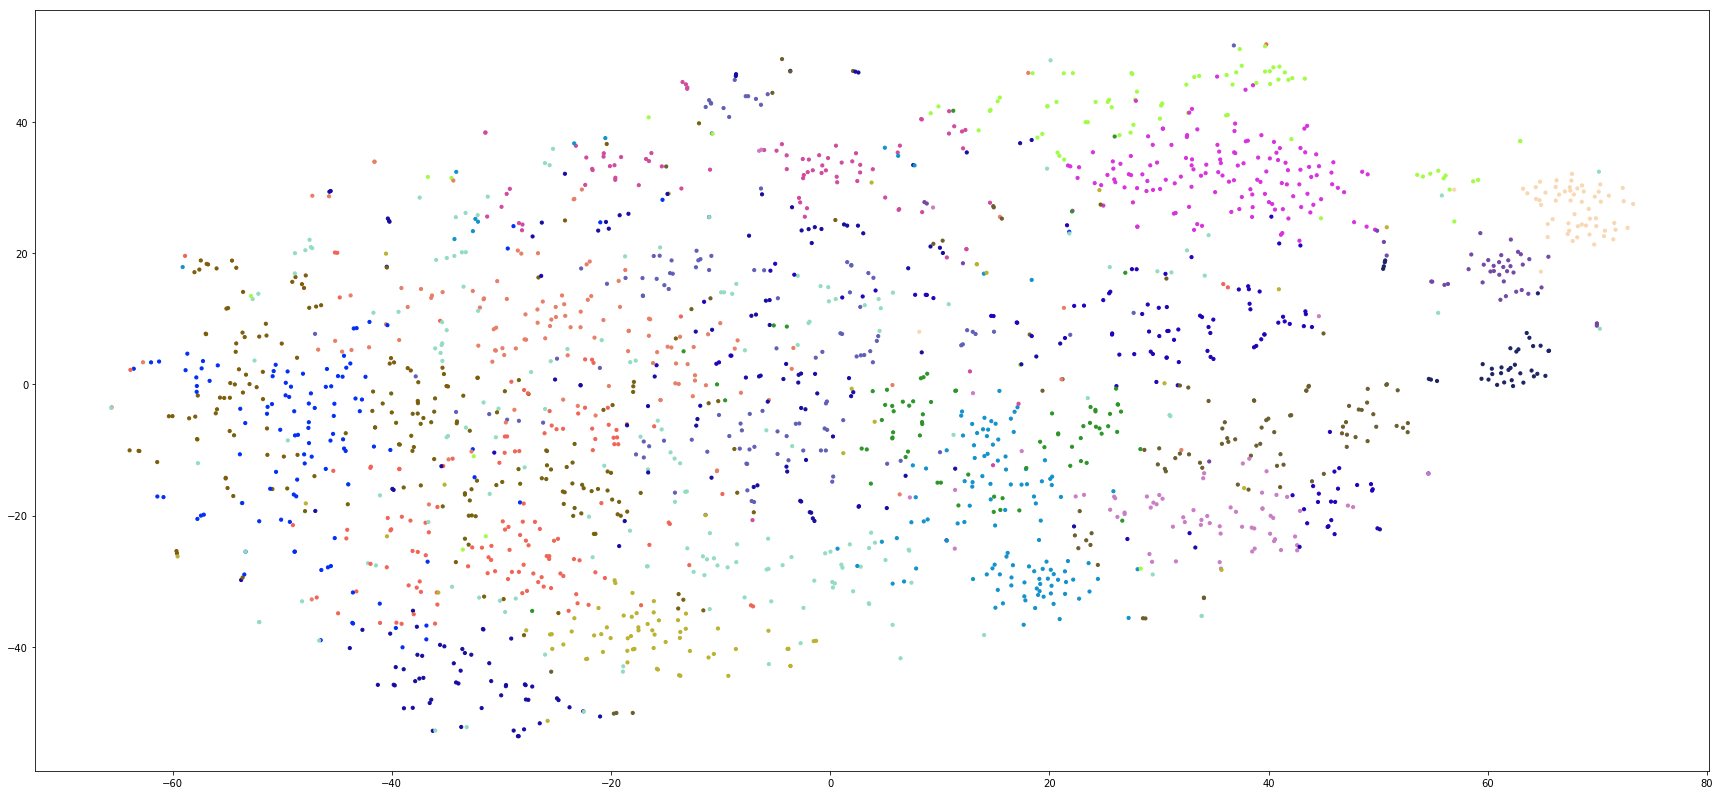

In [96]:
import matplotlib.pyplot as plt
import random

def random_color():
    return (
        random.random(),
        random.random(),
        random.random()
    )

colors = [random_color() for _ in range(20)]

plt.scatter(result[:, 0], result[:, 1], s=10, c=[colors[i] for i in k_means_fit])
plt.rcParams['figure.figsize'] = [30, 14]
plt.show()